In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, precision_recall_fscore_support, classification_report, recall_score

In [2]:
data = pd.read_csv('dataset_57_hypothyroid.csv', header=0)
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [3]:
data = data.replace({'f': 0, 't': 1, '?': np.nan})
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,0,0,0,0,0,0,0,0,...,1,125,1,1.14,1,109,0,NaN,SVHC,negative
1,23,F,0,0,0,0,0,0,0,0,...,1,102,0,NaN,0,NaN,0,NaN,other,negative
2,46,M,0,0,0,0,0,0,0,0,...,1,109,1,0.91,1,120,0,NaN,other,negative
3,70,F,1,0,0,0,0,0,0,0,...,1,175,0,NaN,0,NaN,0,NaN,other,negative
4,70,F,0,0,0,0,0,0,0,0,...,1,61,1,0.87,1,70,0,NaN,SVI,negative


In [4]:
data['TSH'] = data['TSH'].astype('float')
data['T3'] = data['T3'].astype('float')
data['TT4'] = data['TT4'].astype('float')
data['FTI'] = data['FTI'].astype('float')
data['T4U'] = data['T4U'].astype('float')

## Dealing with NaNs

In [5]:
data.isna().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

We will drop TBG column since it has no useful values:

In [6]:
data.drop('TBG', inplace=True, axis=1)

For every hormone column we have an additional one that says if the value of the hormone was measured or not (in the lower cell we can see that the NaNs in hormone collumn correspond with the 0-value in the measurment column):

In [7]:
for col in ['TSH', 'TT4', 'T4U', 'FTI']:
    print(data[(data[col].isna() & (data['{}_measured'.format(col)] == 0)) | (~data[col].isna() & (data['{}_measured'.format(col)] == 1))].shape[0])

3772
3772
3772
3772


Let's drop the "..measured" columns, since they don't contain any useful information for us: 

In [8]:
data.drop([col for col in data.columns if 'measured' in col], axis=1, inplace=True)

In [9]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

Let's take a closer look at the sex and age columns in terms of NaNs. (Looking in the future, we can tell that they are not really significant in terms of classifying hypthyroid disease, so maybe we can somehow fill them with mean/median values)

In [10]:
data[data.sex.isna() | data.age.isna()].Class.value_counts()

negative                   140
compensated_hypothyroid      7
primary_hypothyroid          4
Name: Class, dtype: int64

We can see that NaN sex and age rows contain some primary and compensated hypothyroid patients, which can be important considering the overall greatly unbalanced labels in our dataset, so let's not drop them and just make them all males.

In [11]:
data.sex = data.sex.fillna('M')

Considering age, let's just fill it with median value:

In [12]:
data.age = data.age.fillna(data.age.median())

In [13]:
data.isna().sum()

age                            0
sex                            0
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

In [14]:
data[['TSH', 'T3', 'TT4', 'FTI', 'T4U']].describe()

,TSH,T3,TT4,FTI,T4U
count,3403.000000,3003.000000,3541.000000,3387.000000,3385.000000
mean,5.086766,2.013500,108.319345,110.469649,0.995000
std,24.521470,0.827434,35.604248,33.089698,0.195457
min,0.005000,0.050000,2.000000,2.000000,0.250000
25%,0.500000,1.600000,88.000000,93.000000,0.880000
50%,1.400000,2.000000,103.000000,107.000000,0.980000
75%,2.700000,2.400000,124.000000,124.000000,1.080000
max,530.000000,10.600000,430.000000,395.000000,2.320000


In [15]:
data['TSH'] = data['TSH'].fillna(data['TSH'].median())
data['T3'] = data['T3'].fillna(data['T3'].median())
data['TT4'] = data['TT4'].fillna(data['TT4'].median())
data['FTI'] = data['FTI'].fillna(data['FTI'].median())
data['T4U'] = data['T4U'].fillna(data['T4U'].median())

data.index = pd.RangeIndex(data.shape[0])  # Fixing the index

### A couple of words about the target classes

In [16]:
data.Class.value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In the upper cell, we can see that the classes are strongly unbalanced (we have much smaller amount of ill people compared to the number of thyroid-negative people), so our main purpose will be to achieve a high value of recall in our predictions, since we obviously want to diagnoze as many actually thyroid-positive people as possible.

We also have to few persons with secondary hypothyroid (only 2 of them), this will only cause us us trouble with building a model, so let's just assume that these people actually have primary hypothyroid.

In [17]:
data.Class.replace({'secondary_hypothyroid': 'primary_hypothyroid'}, inplace=True)
data.Class.value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          97
Name: Class, dtype: int64

## Normalizing the data and encoding the variables

Encoding:

In [18]:
target_encoding = {
    'negative': 0,
    'compensated_hypothyroid': 1,
    'primary_hypothyroid': 2
}
data['Class'] = data['Class'].replace(target_encoding)

source_encoding = {value: number for number, value in enumerate(set(data['referral_source']))}  # Can't set any order here, those values are defintely uncomparable
print(source_encoding)
data['referral_source'] = data['referral_source'].replace(source_encoding)

sex_encoding = {'F': 1, 'M': 0}
data['sex'] = data['sex'].replace(sex_encoding)

{'STMW': 0, 'other': 1, 'SVHC': 2, 'SVHD': 3, 'SVI': 4}


Normalizing (first of all, let's find all the columns with continious values):

In [19]:
for col in data.columns:
    if set(data[col]) != {0, 1}:
        print(col)

age
TSH
T3
TT4
T4U
FTI
referral_source
Class


In [20]:
data[['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'age']] = StandardScaler().fit_transform(data[['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'age']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,-0.534694,1,0,0,0,0,0,0,0,0,...,0,0,0,-0.146958,0.662778,0.492718,0.791301,-0.035561,2,0
1,-1.431123,1,0,0,0,0,0,0,0,0,...,0,0,0,-0.026856,-0.014560,-0.173649,-0.072687,-0.099320,1,0
2,-0.285686,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.160684,-0.014560,0.029158,-0.450682,0.315109,1,0
3,0.909553,1,1,0,0,0,0,0,0,0,...,0,0,0,-0.195857,-0.150027,1.941342,-0.072687,-0.099320,1,0
4,0.909553,1,0,0,0,0,0,0,0,0,...,0,0,0,-0.171836,-1.098300,-1.361521,-0.666679,-1.278846,4,0


# Analyzing the data

In [22]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [23]:
def color_plot(x, y, labels):
    color_map = {0: 'red', 1: 'blue', 2: 'green'}
    plt.figure(figsize=(15, 8))
    colors = labels.map(color_map)
    plt.scatter(x, y, c=colors, s=5)
    plt.show()

TSH and T3


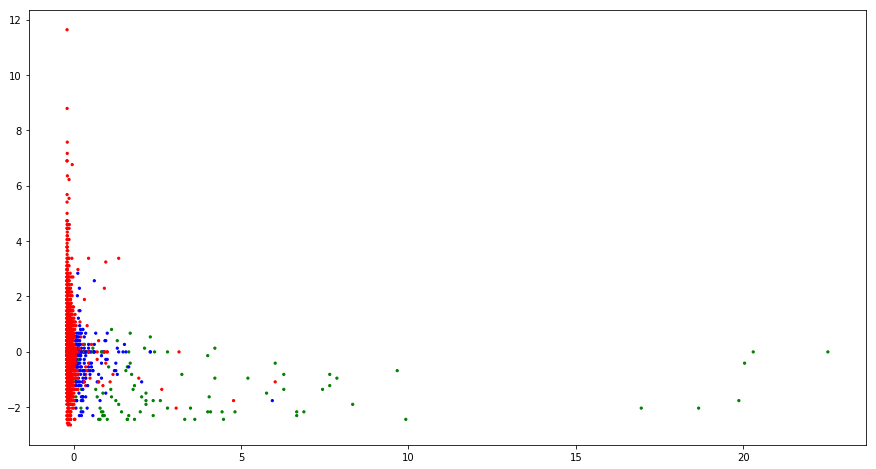

TSH and T4U


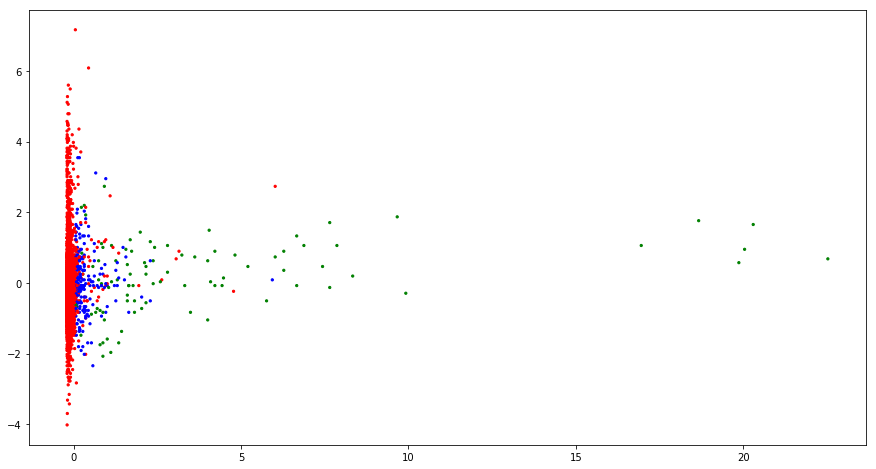

TSH and FTI


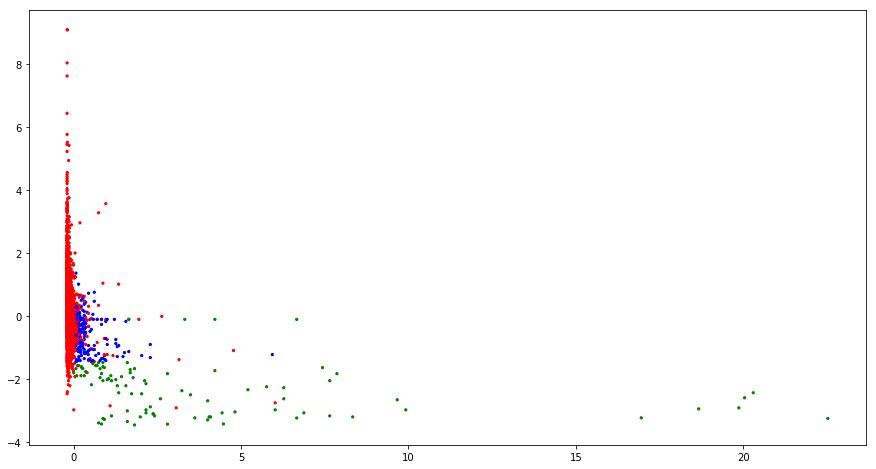

T3 and FTI


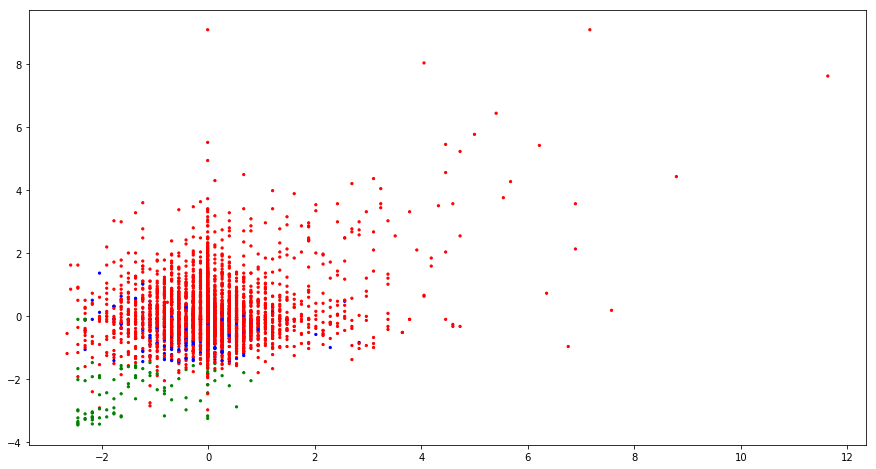

TT4 and TSH


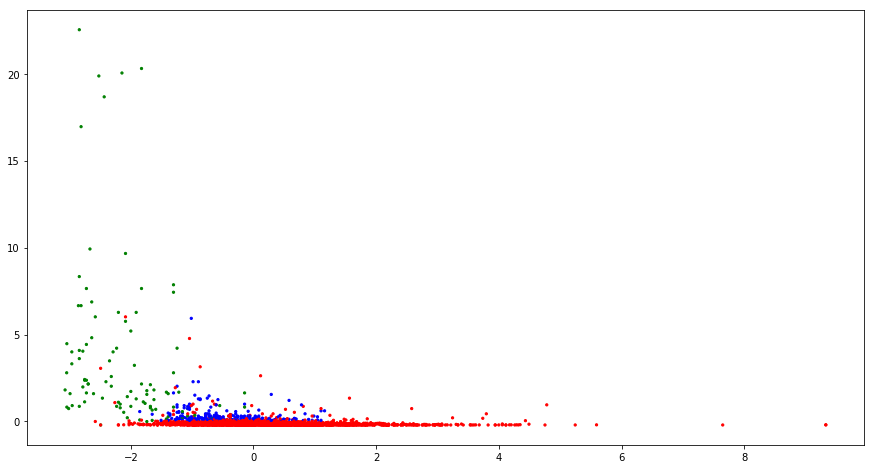

TT4 and T3


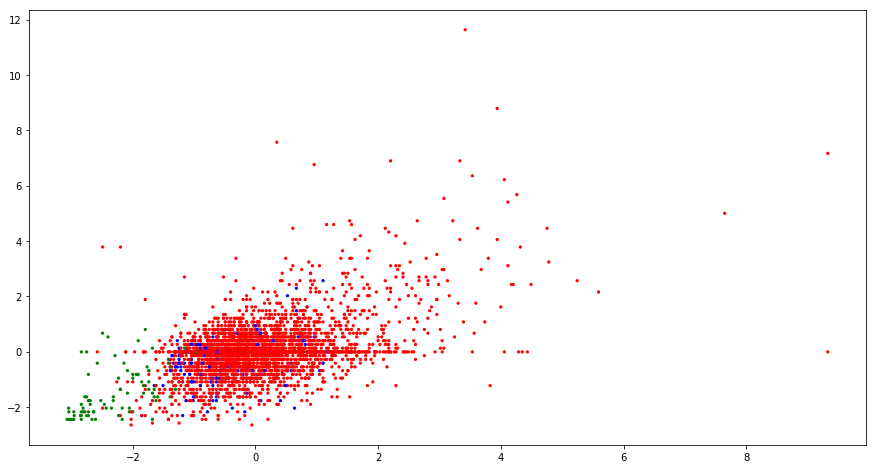

TT4 and T4U


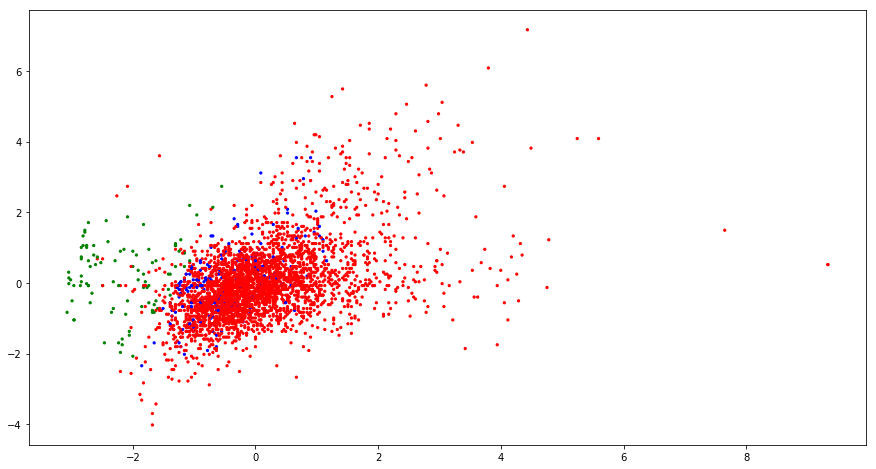

TT4 and FTI


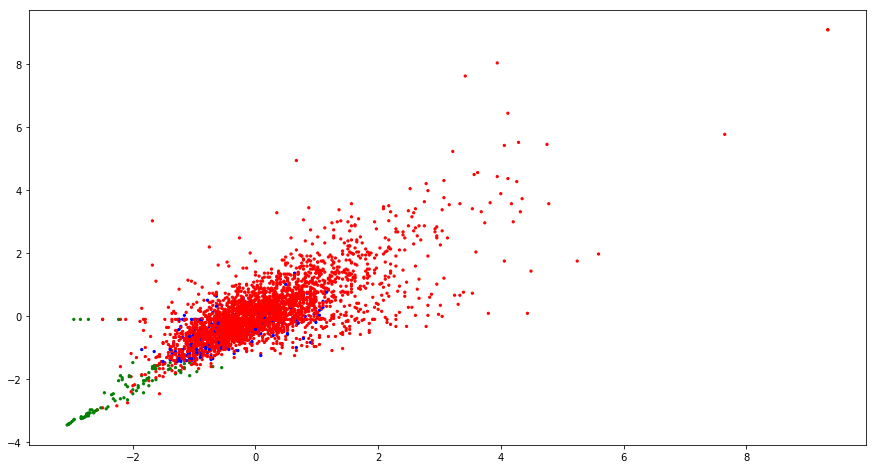

T4U and T3


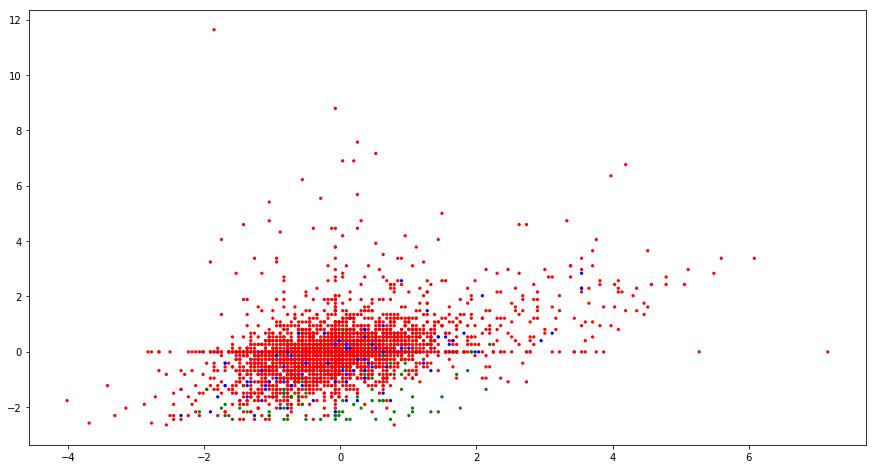

T4U and FTI


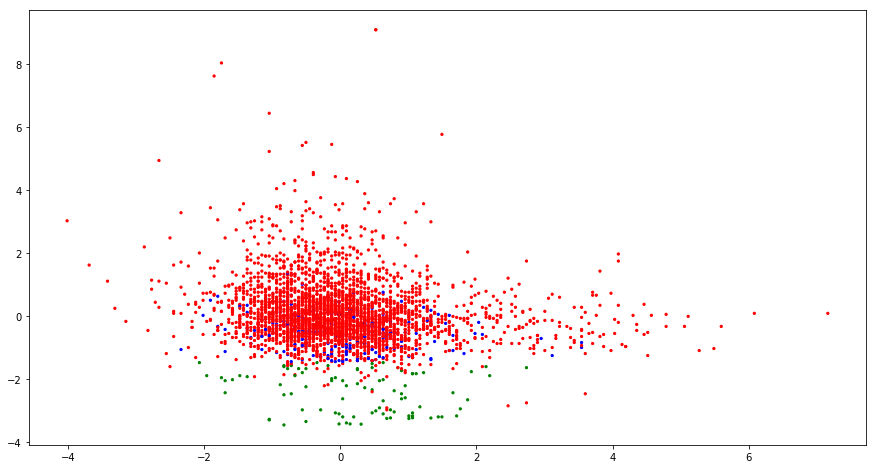

In [24]:
for col1 in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    for col2 in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
        if col1 > col2:
            print('{} and {}'.format(col1, col2))
            color_plot(data[col1], data[col2], data['Class'])

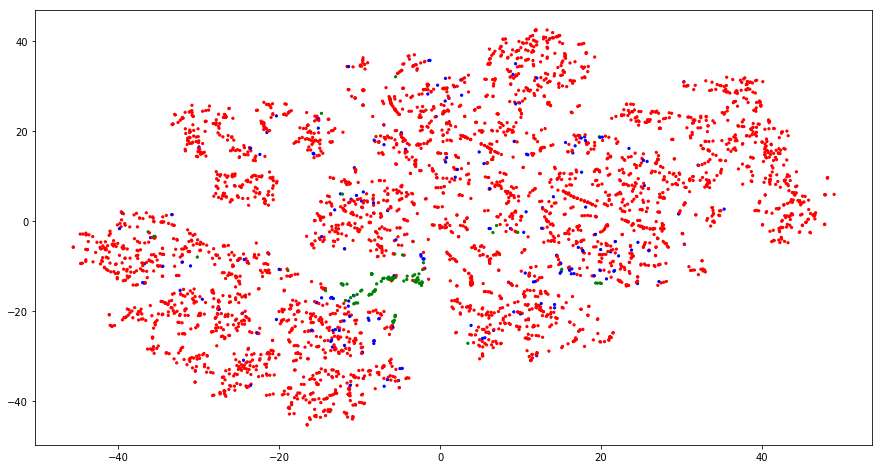

In [25]:
data_for_tsne = data[[col for col in data.columns if col != 'Class']]

tsne = TSNE(n_jobs=2, n_components=2, n_iter=1000, perplexity=20)
reduced_data = tsne.fit_transform(data_for_tsne)
color_plot(reduced_data[:, 0], reduced_data[:, 1], data.Class)

After looking at those plots, we can formulate our main problem: we can separate the 0-labels (people who are absolutely healthy in terms of hypothyroid disease) and 2-labels (people who are suffering from this illness) pretty easily (which is good, our main purpose is exactly to classify the sick people well), but we will have some big trouble with 1-labels (people with compensated hypothyroid disease), since they are easily confused with both other classes (we can see this on the most of the hormone plots and in the T-SNE plot).  

## Train/test split

In [26]:
train, test = train_test_split(data, test_size=0.3)
print(train.Class.value_counts())
print(test.Class.value_counts())

0    2431
1     140
2      69
Name: Class, dtype: int64
0    1050
1      54
2      28
Name: Class, dtype: int64


In [27]:
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve


def evaluate_model(train, test, model, feature_cols, sample_weights=None):
    if sample_weights is None:
        model.fit(train[feature_cols], train['Class'])
    else:
        model.fit(train[feature_cols], train['Class'], sample_weight=sample_weights)
    scores = model.predict(test[feature_cols])

    report = classification_report(test.Class, scores)
    recall = recall_score(test.Class, scores, labels=[1, 2], average='macro')
    
    return recall, report

# K Nearest Neighbours modelling

We will be using KNN model with 1-10 neighbors, using euclidian distance metric and we will use the same distance as an importance function for the nearest neighbors.

In [28]:
cols = ['TSH', 'TT4', 'on_thyroxine']

best_result = (0, 0, 0)

for k in range(1, 100):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='brute', p=2, weights='distance')
    recall, report = evaluate_model(train, test, model, cols)
    
    if recall > best_result[1]:
        best_result = (k, recall, report)

print('Best recall score achieved with number of neighbors {}:'.format(best_result[0]))
print(best_result[2])
print('Recall for 1 and 2 labels: {}'.format(best_result[1]))

Best recall score achieved with number of neighbors 6:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1050
           1       0.94      0.91      0.92        54
           2       0.93      0.89      0.91        28

   micro avg       0.99      0.99      0.99      1132
   macro avg       0.95      0.93      0.94      1132
weighted avg       0.99      0.99      0.99      1132

Recall for 1 and 2 labels: 0.9001322751322751


# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'referral_source', 'Class'],
      dtype='object')

In [31]:
def feature_importances(model, cols):
    feature_importances = pd.DataFrame({value: model.coef_[value] for value in [0, 1, 2]})
    feature_importances.index = cols
    return feature_importances

First of all, let's try the Logistic Regression without any class balancing at all, using all of the columns in our dataset:

In [32]:
cols = list(set(data.columns) - {'Class'})

In [34]:
model = LogisticRegression(max_iter=50, solver='saga', multi_class='multinomial', penalty='l1')

recall, report = evaluate_model(train, test, model, cols)
print(report)
print(recall)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1050
           1       0.88      0.26      0.40        54
           2       0.83      0.86      0.84        28

   micro avg       0.96      0.96      0.96      1132
   macro avg       0.89      0.70      0.74      1132
weighted avg       0.95      0.96      0.95      1132

0.5582010582010581


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The recall for 1-label is unacceptably low, let's try to figure out the problem. First of all, let's try to add class balancing:

In [35]:
model = LogisticRegression(max_iter=50, solver='saga', multi_class='multinomial', penalty='l1', class_weight='balanced')

recall, report = evaluate_model(train, test, model, cols)
print(report)
print(recall)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1050
           1       0.66      0.94      0.78        54
           2       0.66      0.96      0.78        28

   micro avg       0.96      0.96      0.96      1132
   macro avg       0.77      0.96      0.85      1132
weighted avg       0.97      0.96      0.97      1132

0.9543650793650793


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


This is way better, but we still can improve the scores a little bit. Let's take a look at feature importances:

In [36]:
feature_importances(model, cols)

,0,1,2
on_antithyroid_medication,0.124682,0.000000,-0.246021
query_hyperthyroid,0.183297,0.453026,-0.977733
psych,0.594899,-0.087111,-0.194660
referral_source,-0.000003,-0.050764,0.070412
query_on_thyroxine,0.000000,0.467912,-0.622194
sick,0.000000,0.548153,-0.793494
TSH,-9.658998,4.528892,4.818052
age,0.134574,0.212369,-0.632546
I131_treatment,0.000000,-0.077778,0.080787
TT4,0.864510,0.565692,-1.739017


Looks like we have a lot of useless columns, let's leave only the features with high maximal per-class performance:

In [37]:
feature_importance = feature_importances(model, cols)
feature_importance['max'] = np.max(abs(feature_importance), axis=1)
feature_importance = feature_importance[feature_importance['max'] > 1]

feature_importance

,0,1,2,max
TSH,-9.658998,4.528892,4.818052,9.658998
TT4,0.864510,0.565692,-1.739017,1.739017
FTI,0.451693,0.451930,-1.101163,1.101163
thyroid_surgery,1.151068,-0.791612,-0.020703,1.151068
on_thyroxine,2.420551,-2.328169,-0.026898,2.420551


In [38]:
selected_features = ['TSH', 'TT4', 'on_thyroxine', 'T4U']

In [39]:
model = LogisticRegression(max_iter=50, solver='saga', multi_class='multinomial', class_weight='balanced')

recall, report = evaluate_model(train, test, model, selected_features)
print(report)
print(recall)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1050
           1       0.70      0.98      0.82        54
           2       0.64      1.00      0.78        28

   micro avg       0.97      0.97      0.97      1132
   macro avg       0.78      0.98      0.86      1132
weighted avg       0.98      0.97      0.97      1132

0.9907407407407407


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


This is an outstanding result because of multiple reasons:
    1. We found all the patients who are suffering from the primary hypothyroid.
    2. We never classify a patient with hypothyroid (compensated or not) as a healthy one.
    3. We found almost all the patients with compensated hypothyroid (2% were missed)
    4. Only 4% healthy patients were classified as hypothyroid-sick (both compensated and primary) 

But we are not done yet, let's try to imrove our scores even more, using over/undersampling techniques:

## Oversampling

In [70]:
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, BorderlineSMOTE

In [55]:
selected_features

['TSH', 'TT4', 'on_thyroxine', 'T4U']

In [74]:
X, y = train[selected_features], train['Class']
X_resampled, y_resampled = SMOTENC(categorical_features=[2], random_state=0).fit_resample(X, y)
train_resampled = pd.DataFrame(X_resampled, columns=selected_features)
train_resampled['Class'] = y_resampled

In [75]:
model = LogisticRegression(max_iter=500, solver='saga', multi_class='multinomial', class_weight='balanced')

recall, report = evaluate_model(train_resampled, test, model, selected_features)
print(report)
print(recall)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1050
           1       0.73      0.98      0.83        54
           2       0.70      1.00      0.82        28

   micro avg       0.97      0.97      0.97      1132
   macro avg       0.81      0.98      0.88      1132
weighted avg       0.98      0.97      0.97      1132

0.9907407407407407


## Undersampling

In [82]:
from imblearn.under_sampling import ClusterCentroids, NearMiss

In [83]:
X, y = train[selected_features], train['Class']
X_resampled, y_resampled = NearMiss(random_state=0).fit_resample(X, y)
train_resampled = pd.DataFrame(X_resampled, columns=selected_features)
train_resampled['Class'] = y_resampled

In [84]:
model = LogisticRegression(max_iter=100, solver='saga', multi_class='multinomial', class_weight='balanced')

recall, report = evaluate_model(train_resampled, test, model, selected_features)
print(report)
print(recall)

              precision    recall  f1-score   support

           0       0.95      0.14      0.24      1050
           1       0.05      0.93      0.10        54
           2       0.86      0.89      0.88        28

   micro avg       0.20      0.20      0.20      1132
   macro avg       0.62      0.65      0.41      1132
weighted avg       0.91      0.20      0.25      1132

0.9093915343915344


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
